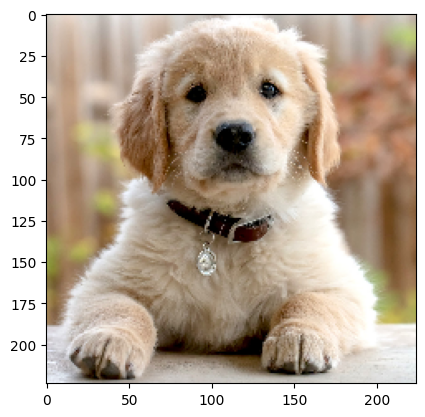

In [1]:
import os
import urllib.request as urllib
import tarfile
import sys
import numpy as np
from tensorflow import keras
import matplotlib.pyplot as plt

image_path = './dog.jpeg'
img = keras.utils.load_img(image_path, target_size=(224, 224))
plt.imshow(img)
plt.show()

In [2]:
HEIGHT, WIDTH, DEPTH = 96, 96, 3
N_CLASSES = 10
SIZE = HEIGHT*WIDTH*DEPTH
DATA_DIR = './stl10_data'
# DATA_URL = 'http://ai.stanford.edu/~acoates/stl10/stl10_binary.tar.gz'
# DATA_URL = 'stl10_binary.tar.gz'
TRAIN_DATA_PATH = DATA_DIR + '/stl10_binary/train_X.bin'
TEST_DATA_PATH = DATA_DIR+'/stl10_binary/test_X.bin'
TRAIN_LABELS_PATH = DATA_DIR + '/stl10_binary/train_y.bin'
TEST_LABELS_PATH = DATA_DIR + '/stl10_binary/test_y.bin'
CLASS_NAMES_PATH = DATA_DIR + '/stl10_binary/class_names.txt'

In [3]:
def read_labels(path_to_labels):
  with open(path_to_labels, 'rb') as f:
    labels = np.fromfile(f, dtype=np.uint8)
    return labels

def read_all_images(path_to_data):
  with open(path_to_data, 'rb') as f:
    everything = np.fromfile(f, dtype=np.uint8)
    images = np.reshape(everything, (-1, DEPTH, WIDTH, HEIGHT))
    images = np.transpose(images, (0, 3, 2, 1))
    return images

def download_and_extract():
  if all((
     os.path.exists(TRAIN_DATA_PATH),
     os.path.exists(TEST_DATA_PATH),
     os.path.exists(TRAIN_LABELS_PATH),
     os.path.exists(TEST_LABELS_PATH)
  )):
    return

  dest_directory = DATA_DIR
  if not os.path.exists(dest_directory):
    os.makedirs(dest_directory)

  filename = DATA_URL.split('/')[-1]
  filepath = os.path.join(dest_directory, filename)
  if not os.path.exists(filepath):
    def _progress(count, block_size, total_size):
      sys.stdout.write('\rDownloading %s %.2f%%' % (filename,
                                                    float(count*block_size)/ float(total_size)*100.0))
      sys.stdout.flush()
    filepath, _ = urllib.urlretrieve(DATA_URL, filepath, reporthook=_progress)
    print('Downloaded', filename)
    tarfile.open(filepath, 'r:gz').extractall(dest_directory)

def load_dataset():
#   download_and_extract()

  x_train = read_all_images(TRAIN_DATA_PATH)
  y_train = read_labels(TRAIN_LABELS_PATH)
  x_test = read_all_images(TEST_DATA_PATH)
  y_test = read_labels(TEST_LABELS_PATH)

  x_train = x_train.astype('float32')
  x_train = (x_train - 127.5) / 127.5
  x_test = x_test.astype('float32')
  x_test = (x_test - 127.5) / 127.5

  y_train -= 1
  y_test -= 1

  y_train = keras.utils.to_categorical(y_train, N_CLASSES)
  y_test = keras.utils.to_categorical(y_test, N_CLASSES)

  return (x_train, y_train), (x_test, y_test)

In [4]:
(x_train, y_train), (x_test, y_test) = load_dataset()
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(5000, 96, 96, 3) (5000, 10) (8000, 96, 96, 3) (8000, 10)


In [5]:
model = keras.Sequential([
    keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(x_train.shape[1], x_train.shape[2], 3), padding='same'),
    keras.layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    keras.layers.MaxPooling2D((2, 2)),
    
    keras.layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    keras.layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    keras.layers.MaxPooling2D((2, 2)),
    
    keras.layers.Conv2D(256, (3,3), activation='relu', padding='same'),
    keras.layers.Conv2D(256, (3,3), activation='relu', padding='same'),
    keras.layers.Conv2D(256, (3,3), activation='relu', padding='same'),
    keras.layers.MaxPooling2D((2, 2)),
    
    keras.layers.Conv2D(512, (3,3), activation='relu', padding='same'),
    keras.layers.Conv2D(512, (3,3), activation='relu', padding='same'),
    keras.layers.Conv2D(512, (3,3), activation='relu', padding='same'),
    keras.layers.MaxPooling2D((2, 2)),
    
    keras.layers.Conv2D(512, (3,3), activation='relu', padding='same'),
    keras.layers.Conv2D(512, (3,3), activation='relu', padding='same'),
    keras.layers.Conv2D(512, (3,3), activation='relu', padding='same'),
    keras.layers.MaxPooling2D((2, 2)),
    
    keras.layers.Flatten(),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 96, 96, 64)        1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 96, 96, 64)        36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 48, 48, 64)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 48, 48, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 48, 48, 128)       147584    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 24, 24, 128)      0         
 2D)                                                    

In [6]:
optimizer = keras.optimizers.Adam(learning_rate=0.00001)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy']
              )
history = model.fit(x_train, y_train, epochs=100, batch_size=32, validation_data=(x_test, y_test))

Epoch 1/100
157/157 [==============================] - 18s 86ms/step - loss: 2.2978 - accuracy: 0.1050 - val_loss: 2.2506 - val_accuracy: 0.1673
Epoch 2/100
157/157 [==============================] - 13s 81ms/step - loss: 2.0818 - accuracy: 0.2198 - val_loss: 1.9175 - val_accuracy: 0.2871
Epoch 3/100
157/157 [==============================] - 13s 84ms/step - loss: 1.8594 - accuracy: 0.2844 - val_loss: 1.7131 - val_accuracy: 0.3295
Epoch 4/100
157/157 [==============================] - 13s 84ms/step - loss: 1.7451 - accuracy: 0.3122 - val_loss: 1.6794 - val_accuracy: 0.3534
Epoch 5/100
157/157 [==============================] - 13s 85ms/step - loss: 1.6885 - accuracy: 0.3422 - val_loss: 1.6096 - val_accuracy: 0.3729
Epoch 6/100
157/157 [==============================] - 13s 85ms/step - loss: 1.6307 - accuracy: 0.3584 - val_loss: 1.5885 - val_accuracy: 0.3645
Epoch 7/100
157/157 [==============================] - 13s 85ms/step - loss: 1.5927 - accuracy: 0.3778 - val_loss: 1.5338 - val_ac

157/157 [==============================] - 13s 82ms/step - loss: 0.3537 - accuracy: 0.8748 - val_loss: 1.6178 - val_accuracy: 0.5824
Epoch 58/100
157/157 [==============================] - 13s 82ms/step - loss: 0.3142 - accuracy: 0.8936 - val_loss: 1.6662 - val_accuracy: 0.5932
Epoch 59/100
157/157 [==============================] - 13s 82ms/step - loss: 0.2960 - accuracy: 0.8946 - val_loss: 1.5492 - val_accuracy: 0.5931
Epoch 60/100
157/157 [==============================] - 13s 82ms/step - loss: 0.2670 - accuracy: 0.9076 - val_loss: 1.7574 - val_accuracy: 0.5916
Epoch 61/100
157/157 [==============================] - 13s 82ms/step - loss: 0.2346 - accuracy: 0.9214 - val_loss: 1.7786 - val_accuracy: 0.5939
Epoch 62/100
157/157 [==============================] - 13s 82ms/step - loss: 0.2221 - accuracy: 0.9276 - val_loss: 1.7735 - val_accuracy: 0.5994
Epoch 63/100
157/157 [==============================] - 13s 82ms/step - loss: 0.1892 - accuracy: 0.9342 - val_loss: 1.9075 - val_accuracy